# Course project

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 8

## Preparation

In [1]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp

In [2]:
from matplotlib import style
style.use('seaborn-v0_8-whitegrid')

## System state space

In [3]:
M = 10
m = 1
g = 9.8
l = 1

In [4]:
A = np.array([
    [0, 1, 0, 0],
    [0, 0, m*g / M, 0],
    [0, 0, 0, 1],
    [0, 0, (M+m)*g / (M*l), 0]
])

B = np.array([
    [0],
    [1/M],
    [0],
    [1/(M*l)]
])

D = np.array([
    [0],
    [1/(M*l)],
    [0],
    [(M+m)/(M*m*l**2)]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

In [5]:
D

array([[0. ],
       [0.1],
       [0. ],
       [1.1]])

In [6]:
np.linalg.eigvals(A)

array([ 0.        ,  0.        ,  3.28329103, -3.28329103])

In [7]:
np.round(np.linalg.eig(A)[1],3)

array([[ 1.   , -1.   ,  0.026, -0.026],
       [ 0.   ,  0.   ,  0.087,  0.087],
       [ 0.   ,  0.   ,  0.29 , -0.29 ],
       [ 0.   ,  0.   ,  0.953,  0.953]])

In [8]:
A_sym = sympy.Matrix(A)
B_sym = sympy.Matrix(B)
P, J = A_sym.jordan_form()
J

Matrix([
[0, 1.0,                0,               0],
[0,   0,                0,               0],
[0,   0, -3.2832910318764,               0],
[0,   0,                0, 3.2832910318764]])

In [9]:
P

Matrix([
[1.0,   0, -0.0276884047215078, 0.0276884047215078],
[  0, 1.0,  0.0909090909090909, 0.0909090909090909],
[  0,   0,  -0.304572451936586,  0.304572451936586],
[  0,   0,                 1.0,                1.0]])

In [10]:
P.inv() @ B_sym

Matrix([
[                 0],
[0.0909090909090909],
[              0.05],
[              0.05]])

In [11]:
C @ P

Matrix([
[1.0, 0, -0.0276884047215078, 0.0276884047215078],
[  0, 0,  -0.304572451936586,  0.304572451936586]])

In [12]:
np.linalg.matrix_rank(np.concatenate([A-(0)*np.identity(4),C]))

4

In [13]:
np.linalg.matrix_rank(np.concatenate([A-(-3.28329103)*np.identity(4),B],axis=1))

4

In [14]:
sys_for_an = ctrl.ss(A, D, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([0.1])], [array([1.1])]], [[array([  1.  ,  -0.  , -10.78])], [array([  1.  ,  -0.  , -10.78])]])

In [15]:
sys_for_an = ctrl.ss(A, B, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([ 1.00000000e-01,  5.88418203e-16, -9.80000000e-01])], [array([0.1, 0. , 0. ])]], [[array([ 1.00000000e+00,  4.99600361e-15, -1.07800000e+01, -1.40229631e-14,
        1.45089866e-14])], [array([ 1.0000000e+00,  3.4622337e-15, -1.0780000e+01,  0.0000000e+00,
        0.0000000e+00])]])

In [16]:
def up_func(t, x, u, params):
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
non_lin_sys = ctrl.NonlinearIOSystem(up_func)
non_lin_sys.set_inputs(2)

In [17]:
time_1 = np.linspace(0,2,int(2/0.001))

In [18]:
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=[0,0,0.05,0])
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=[0,0,0.05,0],U=np.zeros((2,len(time_1))))

Linear

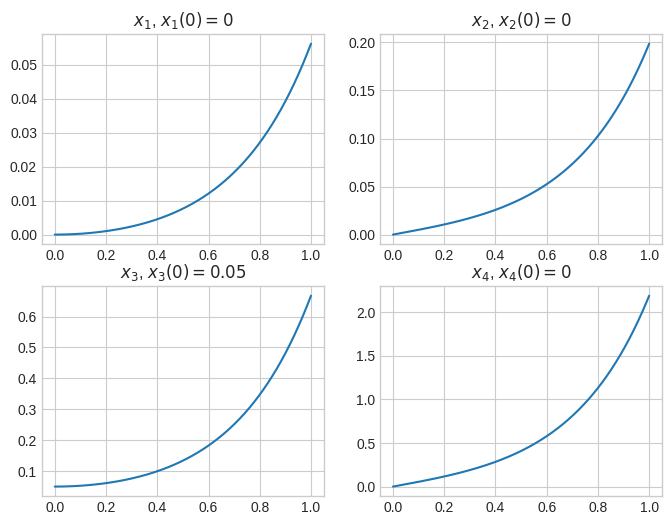

In [19]:
x0 = [0,0,0.05,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

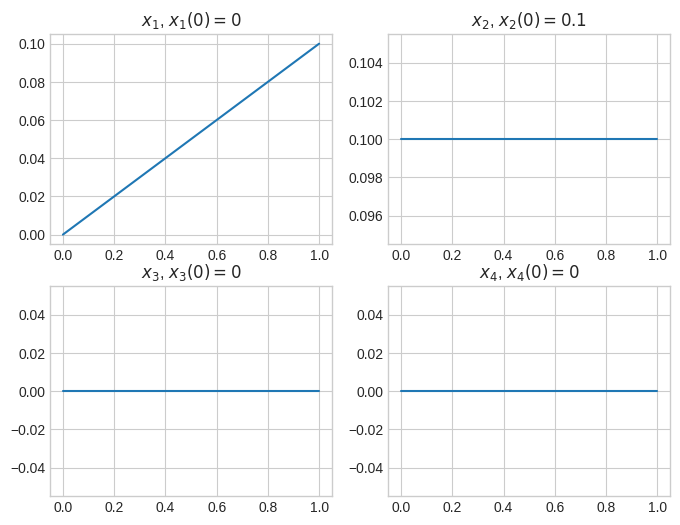

In [20]:
x0 = [0,0.1,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

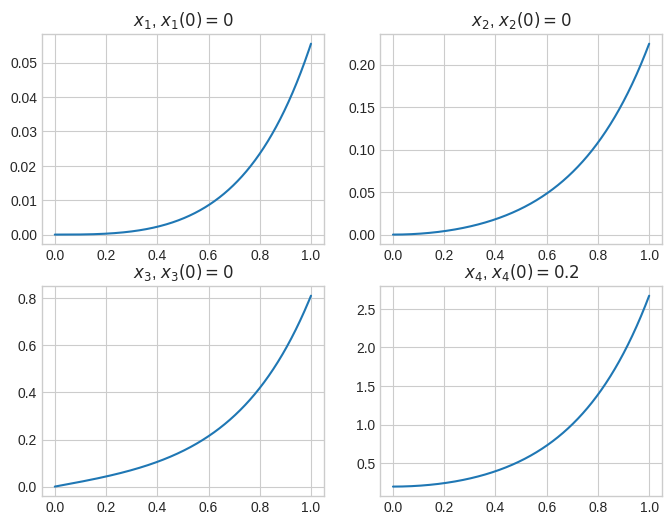

In [21]:
x0 = [0,0,0,0.2]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

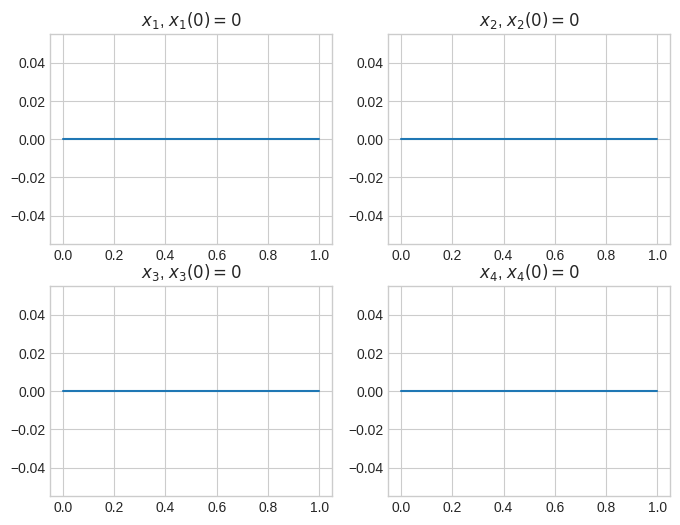

In [22]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

Non-linear

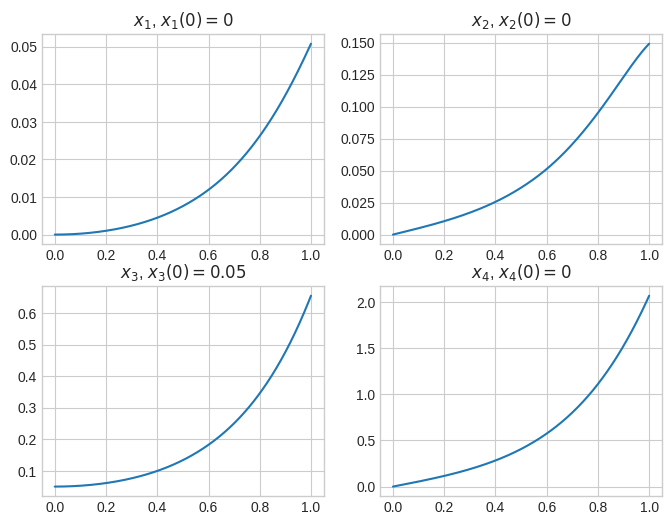

In [23]:
x0 = [0,0,0.05,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

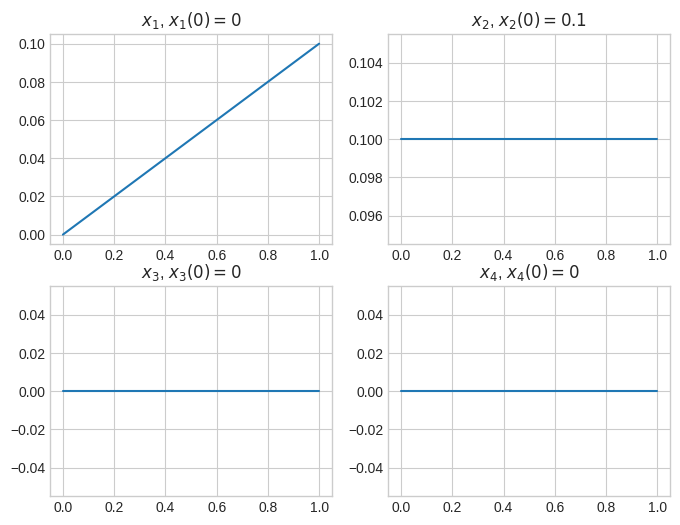

In [24]:
x0 = [0,0.1,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

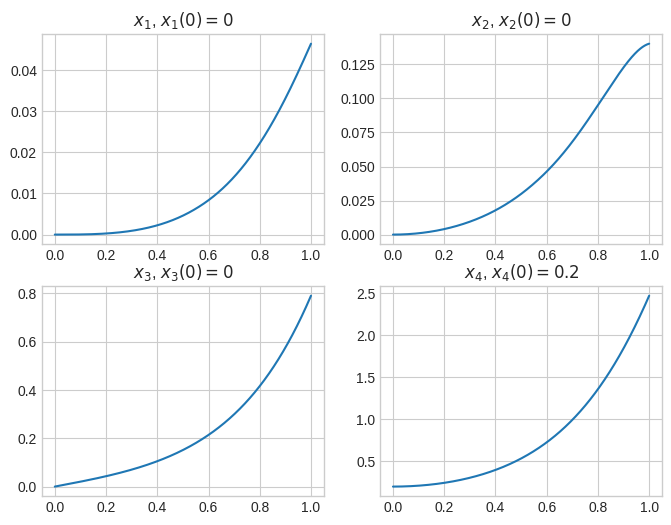

In [25]:
x0 = [0,0,0,0.2]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

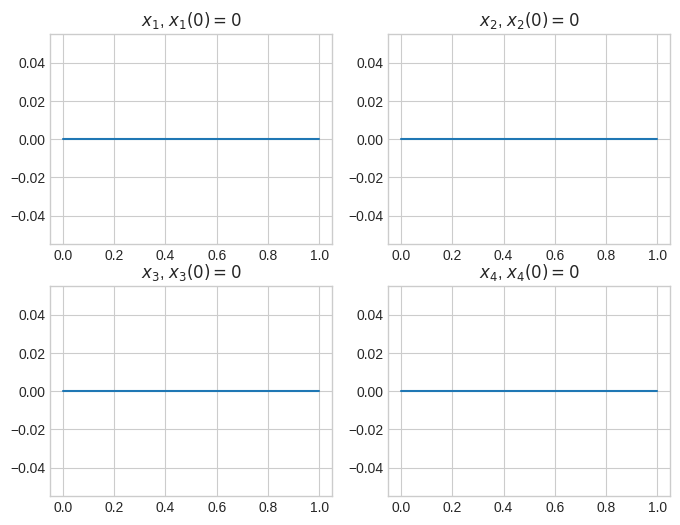

In [26]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

Comparison

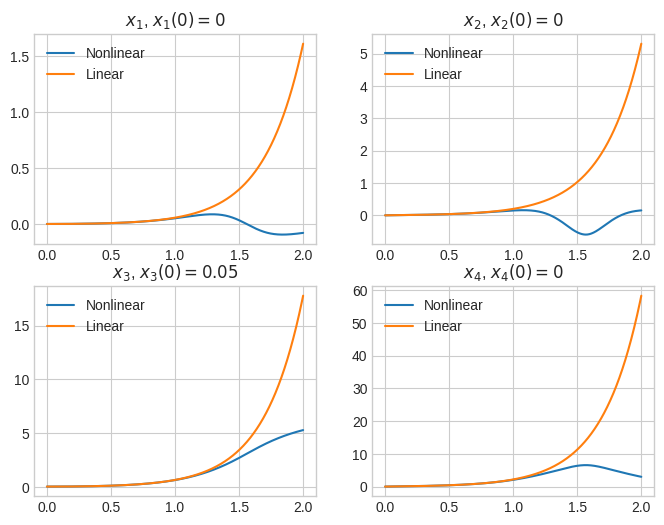

In [32]:
x0 = [0,0,0.05,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

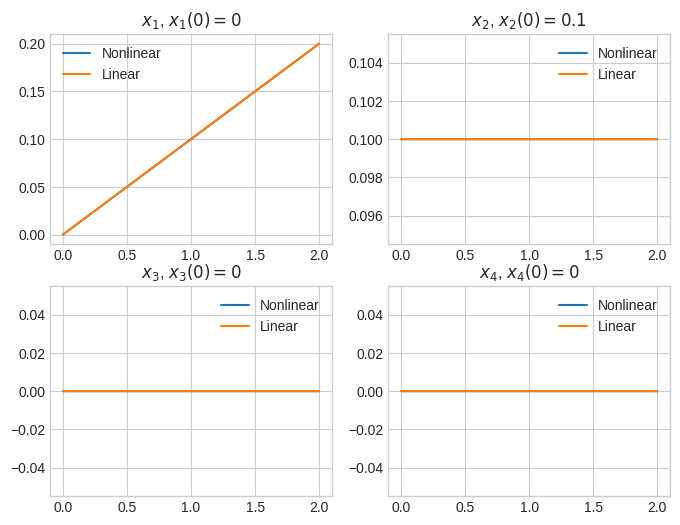

In [33]:
x0 = [0,0.1,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

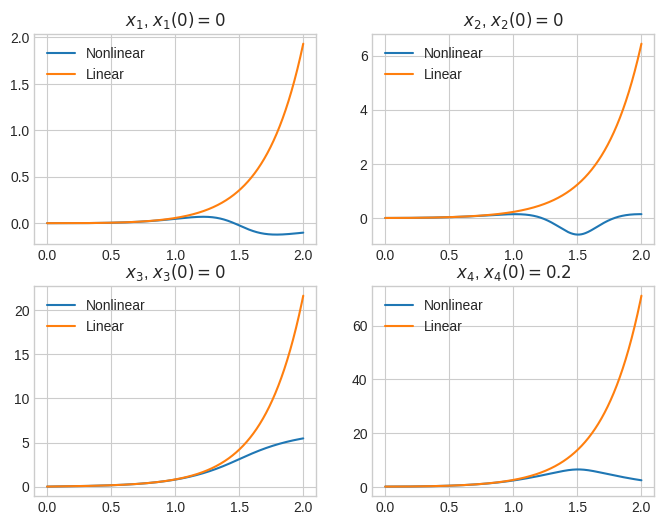

In [34]:
x0 = [0,0,0,0.2]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

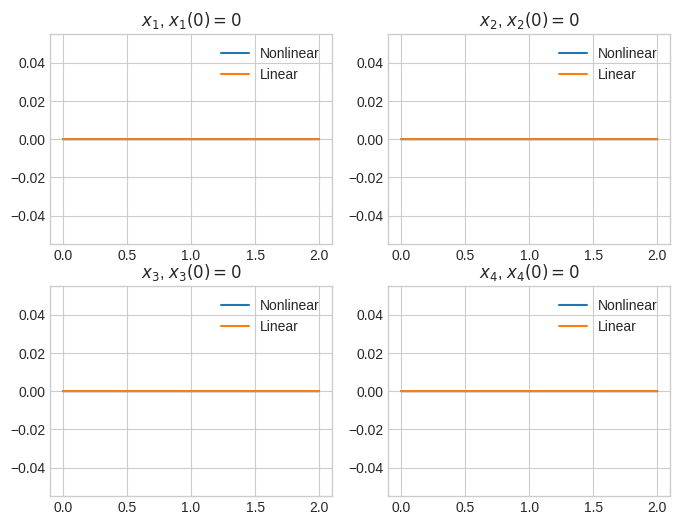

In [35]:
x0 = [0,0,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()